# Стационарное уравнение теплопроводности в 2D

In [1]:
from math import sqrt
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
from matplotlib.animation import FuncAnimation
from tqdm import tqdm_notebook

## Начальные параметры

In [2]:
N = 128
T = np.zeros((N,N))
T = np.random.random((N,N))

dx = 0.1
dV = dx**2

T1 = 50
T0 = 0
T0_internal = 50

q_b = -0.1

L0 = 0.1
Lambda = np.full((N,N), L0)

S_c = np.zeros((N,N))
S_p = np.zeros((N,N))

small = 1e-16

# Определим внутренние граничные условия
blocks= 6    # >= 1


Lambda[(blocks-1)*N//blocks:, :N//blocks] = 1e20
Lambda[(blocks-1)*N//blocks:, (blocks-1)*N//blocks:] = small


M = 1e20

S_c[N*(blocks-1)//(2*blocks):N*(blocks+1)//(2*blocks), N*(blocks-1)//(2*blocks):N*(blocks+1)//(2*blocks)] = M*T0_internal
S_p[N*(blocks-1)//(2*blocks):N*(blocks+1)//(2*blocks), N*(blocks-1)//(2*blocks):N*(blocks+1)//(2*blocks)] = -M

q_b_internal = 15
Lambda[:N//blocks, (blocks-1)*N//blocks:] = small
S_c[N//blocks:N//blocks+2, (blocks-1)*N//blocks:] = q_b_internal * dx / dV

T1_internal = 12
T2_internal = 36
Lambda[:N//blocks, :N//blocks] = small
S_c[N//blocks:N//blocks+2, :N//blocks] = dx/dV * 2*L0/dx * T2_internal
S_p[N//blocks:N//blocks+2, :N//blocks] = -dx/dV * 2*L0/dx

S_c[:N//blocks, N//blocks:N//blocks+2] = dx/dV * 2*L0/dx * T1_internal
S_p[:N//blocks, N//blocks:N//blocks+2] = -dx/dV * 2*L0/dx


def refreshT():
    """
    Зададим граничные условия на температуру
    """
    
    # внизу  - поток q = 0
    T[0, :] = T[1, :]
    # слева - поток q != 0
    T[:, 0] = T[:, 1] + q_b * dx / L0
    # справа - T = 0
    T[:, -1] = T0
    # внизу - T != 0
    T[-1, :] = T1

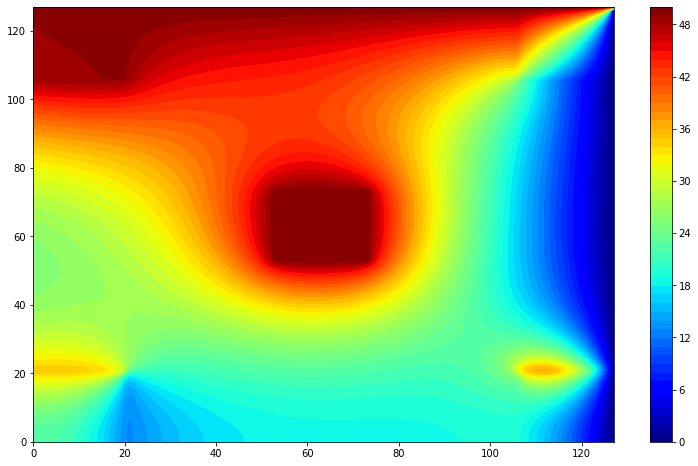

In [3]:
def getab(i,j):
    a_w = 2*Lambda[i,j-1]*Lambda[i,j]/(Lambda[i,j-1]+Lambda[i,j] + small) / dx
    a_n = 2*Lambda[i+1,j]*Lambda[i,j]/(Lambda[i+1,j]+Lambda[i,j] + small) / dx
    a_e = 2*Lambda[i,j+1]*Lambda[i,j]/(Lambda[i,j+1]+Lambda[i,j] + small) / dx
    a_s = 2*Lambda[i-1,j]*Lambda[i,j]/(Lambda[i-1,j]+Lambda[i,j] + small) / dx
    a_p = a_w + a_n + a_e + a_s - S_p[i,j]*dV
    b = S_c[i,j]*dV
    
    return [a_w, a_n, a_e, a_s, a_p, b]


refreshT()

for _ in tqdm_notebook(range(1000)): 
    T_prom = T.copy()
    for i in range(0,N-1):
        P = np.zeros(N)
        Q = np.zeros(N)
        Q[0] = T[i, 0]
        for j in range(0,N-1):            
            a_w, a_n, a_e, a_s, a_p, b = getab(i,j)

            P[j+1] = a_e / (a_p-a_w*P[j])
            Q[j+1] = (a_n*T[i+1,j]+a_s*T[i-1,j]+b + a_w*Q[j])/(a_p-a_w*P[j])

        for j in range(N-2, -1, -1):
            T_prom[i,j] = P[j+1]*T_prom[i,j+1]+Q[j+1]
            
    T = T_prom.copy()
    refreshT()

    for j in range(0,N-1):
        P = np.zeros(N)
        Q = np.zeros(N)
        Q[0] = T[0, j]
        for i in range(0,N-1):
            a_w, a_n, a_e, a_s, a_p, b = getab(i,j)

            P[i+1] = a_n / (a_p-a_s*P[i])
            Q[i+1] = (a_w*T[i,j-1]+a_e*T[i,j+1]+b + a_s*Q[i])/(a_p-a_s*P[i])

        for i in range(N-2, -1, -1):
            T_prom[i,j] = P[i+1]*T_prom[i+1,j]+Q[i+1]
            
    T = T_prom.copy()
    refreshT()
    
    
fig, ax = plt.subplots(figsize = (13,8))
colorinterpolation = 50
colourMap = plt.cm.jet
picture = ax.contourf(T, colorinterpolation, cmap=colourMap)
fig.colorbar(picture)

# fig, ax = plt.subplots(figsize = (4,4))
# picture = ax.imshow(T)
# ax.tick_params(labelcolor='w')
# fig.colorbar(picture)

## Два простых примера

### Фиксированные температуры

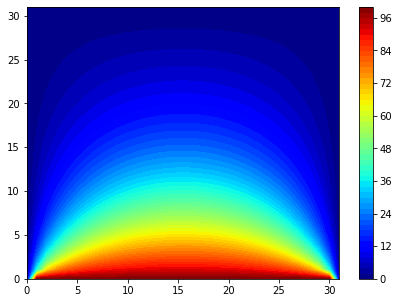

In [10]:
N = 32
T = np.zeros((N,N))
T = np.random.random((N,N))

dx = 0.1
dV = dx**2

T1 = 100
T0 = 0

L0 = 0.1
Lambda = np.full((N,N), L0)

S_c = np.zeros((N,N))
S_p = np.zeros((N,N))

small = 1e-15


def refreshT():
    """
    Зададим граничные условия на температуру
    """
    
    T[0, :] = T1
    T[:, 0] = T0
    T[:, -1] = T0
    T[-1, :] = T0
    
def getab(i,j):
    a_w = 2*Lambda[i,j-1]*Lambda[i,j]/(Lambda[i,j-1]+Lambda[i,j] + small) / dx
    a_n = 2*Lambda[i+1,j]*Lambda[i,j]/(Lambda[i+1,j]+Lambda[i,j] + small) / dx
    a_e = 2*Lambda[i,j+1]*Lambda[i,j]/(Lambda[i,j+1]+Lambda[i,j] + small) / dx
    a_s = 2*Lambda[i-1,j]*Lambda[i,j]/(Lambda[i-1,j]+Lambda[i,j] + small) / dx
    a_p = a_w + a_n + a_e + a_s - S_p[i,j]*dV
    b = S_c[i,j]*dV
    
    return [a_w, a_n, a_e, a_s, a_p, b]


refreshT()

for _ in tqdm_notebook(range(120)): 
    T_prom = T.copy()
    for i in range(0,N-1):
        P = np.zeros(N)
        Q = np.zeros(N)
        Q[0] = T[i, 0]
        for j in range(0,N-1):            
            a_w, a_n, a_e, a_s, a_p, b = getab(i,j)

            P[j+1] = a_e / (a_p-a_w*P[j])
            Q[j+1] = (a_n*T[i+1,j]+a_s*T[i-1,j]+b + a_w*Q[j])/(a_p-a_w*P[j])

        for j in range(N-2, -1, -1):
            T_prom[i,j] = P[j+1]*T_prom[i,j+1]+Q[j+1]
            
    T = T_prom.copy()
    refreshT()

    for j in range(0,N-1):
        P = np.zeros(N)
        Q = np.zeros(N)
        Q[0] = T[0, j]
        for i in range(0,N-1):
            a_w, a_n, a_e, a_s, a_p, b = getab(i,j)

            P[i+1] = a_n / (a_p-a_s*P[i])
            Q[i+1] = (a_w*T[i,j-1]+a_e*T[i,j+1]+b + a_s*Q[i])/(a_p-a_s*P[i])

        for i in range(N-2, -1, -1):
            T_prom[i,j] = P[i+1]*T_prom[i+1,j]+Q[i+1]
            
    T = T_prom.copy()
    refreshT()
    
    
fig, ax = plt.subplots(figsize = (7,5))
colorinterpolation = 50
colourMap = plt.cm.jet
picture = ax.contourf(T, colorinterpolation, cmap=colourMap)
fig.colorbar(picture)

### Две фиксированные температуры и нулевые потонки на стенках

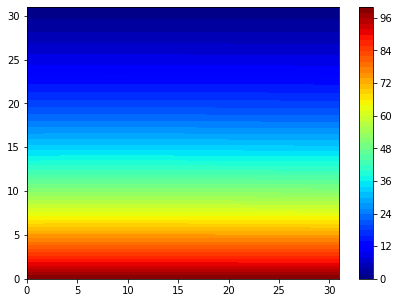

In [11]:
N = 32
T = np.zeros((N,N))
T = np.random.random((N,N))

dx = 0.1
dV = dx**2

T1 = 100
T0 = 0

L0 = 0.1
Lambda = np.full((N,N), L0)

S_c = np.zeros((N,N))
S_p = np.zeros((N,N))

small = 1e-15


def refreshT():
    """
    Зададим граничные условия на температуру
    """
    
    T[0, :] = T1
    T[:, 0] = T[:, 1]
    T[:, -1] = T[:, -2]
    T[-1, :] = T0
    
def getab(i,j):
    a_w = 2*Lambda[i,j-1]*Lambda[i,j]/(Lambda[i,j-1]+Lambda[i,j] + small) / dx
    a_n = 2*Lambda[i+1,j]*Lambda[i,j]/(Lambda[i+1,j]+Lambda[i,j] + small) / dx
    a_e = 2*Lambda[i,j+1]*Lambda[i,j]/(Lambda[i,j+1]+Lambda[i,j] + small) / dx
    a_s = 2*Lambda[i-1,j]*Lambda[i,j]/(Lambda[i-1,j]+Lambda[i,j] + small) / dx
    a_p = a_w + a_n + a_e + a_s - S_p[i,j]*dV
    b = S_c[i,j]*dV
    
    return [a_w, a_n, a_e, a_s, a_p, b]


refreshT()

for _ in tqdm_notebook(range(120)): 
    T_prom = T.copy()
    for i in range(0,N-1):
        P = np.zeros(N)
        Q = np.zeros(N)
        Q[0] = T[i, 0]
        for j in range(0,N-1):            
            a_w, a_n, a_e, a_s, a_p, b = getab(i,j)

            P[j+1] = a_e / (a_p-a_w*P[j])
            Q[j+1] = (a_n*T[i+1,j]+a_s*T[i-1,j]+b + a_w*Q[j])/(a_p-a_w*P[j])

        for j in range(N-2, -1, -1):
            T_prom[i,j] = P[j+1]*T_prom[i,j+1]+Q[j+1]
            
    T = T_prom.copy()
    refreshT()

    for j in range(0,N-1):
        P = np.zeros(N)
        Q = np.zeros(N)
        Q[0] = T[0, j]
        for i in range(0,N-1):
            a_w, a_n, a_e, a_s, a_p, b = getab(i,j)

            P[i+1] = a_n / (a_p-a_s*P[i])
            Q[i+1] = (a_w*T[i,j-1]+a_e*T[i,j+1]+b + a_s*Q[i])/(a_p-a_s*P[i])

        for i in range(N-2, -1, -1):
            T_prom[i,j] = P[i+1]*T_prom[i+1,j]+Q[i+1]
            
    T = T_prom.copy()
    refreshT()
    
    
fig, ax = plt.subplots(figsize = (7,5))
colorinterpolation = 50
colourMap = plt.cm.jet
picture = ax.contourf(T, colorinterpolation, cmap=colourMap)
fig.colorbar(picture)